In [1]:
# IMPORTS

from datetime import datetime

import torch
import warnings
import torch_geometric as geom

from sml_project3 import data
from sml_project3 import mlops
from sml_project3 import utils
from sml_project3 import model
from sml_project3 import painn
from sml_project3 import energy
from sml_project3 import torsion
import mdtraj
import nglview

In [ ]:
import importlib
importlib.reload(painn)
importlib.reload(utils)
importlib.reload(model)

In [ ]:
# MODEL: Basedistribution

class BaseDistribution:
    def __init__(self, ...):
        # TODO: Implement the base distribution for your model. 
        # HINT: The std of the coordinates is 0.1277
        ...
    
    def sample(self, ...):
        # TODO: Implement a sampling function for the basebasedistribtion for your model.
        
        # HINT: This function must return a tensor of dimension [n_atoms, 3]
        ...

In [ ]:
# MODEL: BASELINE MODEL

class BaselineModel:
    def __init__(self, ...):
        # TODO: Implement a baseline model for your experiments
        ...

    def forward(self, batch):
        # TODO: Implement the forward pass of the baseline model.
        # HINT: This function must return a tensor of dimension [n_atoms, 3]
        ...


In [ ]:
# MODEL: Equivariant readout 

class EquivariantReadout(torch.nn.Module):
    def __init__(self, ...):
        super().__init__()
        # TODO: Implement the equivariant readout function for a the painn model 
        ...

    
    def forward(self, batch):
        # TODO: Implement the readout function for the painn model which embeds all nodes
        # with invariant and equivariant features
    
        # HINT: The input batch will have in and equivariant on it with shapes
        # batch.equivariant_features.shape == (n_atoms, n_features, 3)
        # batch.invariant_features.shape == (n_atoms, n_features) 

        # HINT: This function should return a tensor of shape [n_atoms, 3]
        ... 

In [ ]:
# SETUP: set up the training script

readout = Readout(...) # Should take the same number of features as your painn model
basedistribution = BaseDistribution(...)
score = painn.Painn(n_features=8, readout=readout)
cfm = model.CFM(score, basedistribution)

dataset = data.Pentene1Dataset("data")
dataloader = geom.data.DataLoader(dataset, batch_size=100, shuffle=True)


In [ ]:
# Training

# TODO: Train your model
# Hint you can resume the training of some model using
# cfm = mlops.load("results/model/model_latest.pkl")


timer = utils.Timer()
step = 0

for epoch in range(1000):
    for batch in dataloader:
        t = torch.rand(len(batch)).type_as(batch.pos)
        loss = cfm.get_loss(t, batch)
        cfm.training_step(loss)
        step += 1
        print(
            f"epoch: {epoch}, step: {step}, time passed: {timer}, loss: {loss.item():.4f}",
            end="\r",
        )

        if (step + 1) % 10 == 0:
            # HINT: In order to sample the model will need an example batch from the dataset.
            # The features such as atom numbers, atom_idxs and edge_index are used for the 
            # model to generate a new sample. To get an example batch with 10 conformations 
            # run
            # example_batch = utils.get_example_batch(dataset, 10) 

            # Now we can sample from the model
            samples = cfm.sample(example_batch)

            # HINT mlops.save(object, path) will save the pickled object at path, and likewise
            # object = mlops.load(path) will load back the pickled object. Use this if you want
            # to save your model and samples during training

            mlops.save(cfm, f"results/model/model_{step}.pkl")
            mlops.save(cfm, f"results/model/model_latest.pkl")
            mlops.save(samples, f"results/samples/samples_{step}.pkl")

# HINT using my implementation of the equivariant Readout and a painn model with 8 hidden features 
# I was able to get a loss of 0.037 in 10.000 steps within 20 minutes running locally on my laptop. 

In [ ]:
# SAMPLING:
# TODO: Make samples from your model: 

model = mlops.load("results/model/model_latest.pkl")
example_batch = utils.get_example_batch(dataset, 5000)
samples = cfm.sample(example_batch)

In [ ]:
# HINT Just for a point of reference, I included 1000 samples from a PaiNN model that I trained
# for one hour. 
mlops.save(samples, 'reference/solution_samples.pkl')
utils.nglview_pentene(samples)

In [13]:
energy_evaluator = energy.EnergyEvaluator()
torsion_evaluator = torsion.TorsionEvaluator()

In [19]:
# HINT: the energy evaluator will crash if you feed it a torch.Tensor, the trajectory must
# be a numpy array. 


reference_data = dataset.data[:5000].numpy() 
solution_data = mlops.load('ref_samples/cfm_9999_steps.pkl')

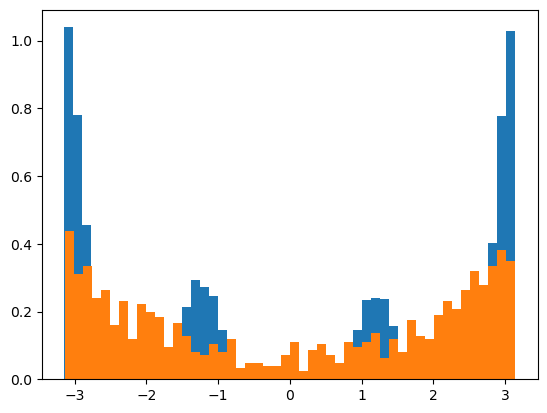

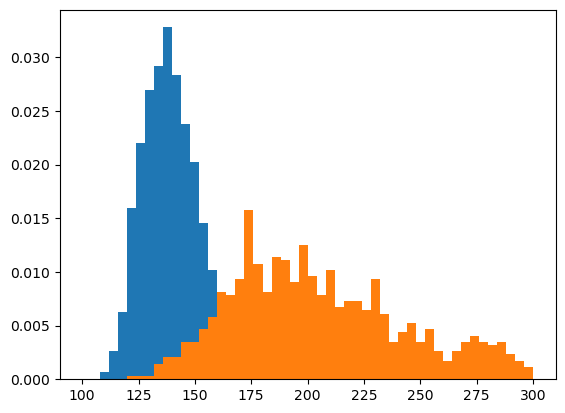

In [18]:
import matplotlib.pyplot as plt



ref_energies = energy_evaluator.evaluate(reference_data)
ref_torsions = torsion_evaluator.evaluate(reference_data)
energies = energy_evaluator.evaluate(samples)
torsions = torsion_evaluator.evaluate(samples)

plt.hist(ref_torsions, bins=50, density=True)
plt.hist(torsions, bins=50, density=True)

plt.show()

plt.hist(ref_energies, bins=50,range=[100,300], density=True)
plt.hist(energies, bins=50, density=True, range=[100,300])
plt.show()

In [25]:
!jupyter nbconvert --version
!pdflatex --version


7.16.4
zsh:1: command not found: pdflatex


In [24]:
!eval "$(/usr/libexec/path_helper)"